# 고양이, 개 분류 - CNN v3
- Dropout 추가
- Kaggle에서 'Copy API Command'를 사용하여 API Key를 발급받을 것
- Full Data로 수행

- 데이터 다운로드 및 압축 해제, 훈련/테스트 데이터 분리

In [1]:
from google.colab import files
up = files.upload()

Saving kaggle.json to kaggle (1).json


In [2]:
import json, os
with open('kaggle.json') as f:
    kaggle = json.load(f)
os.environ['KAGGLE_USERNAME'] = kaggle['username']    # username from the json file
os.environ['KAGGLE_KEY'] = kaggle['key']       # key from the json file

In [3]:
!kaggle datasets download -d shaunthesheep/microsoft-catsvsdogs-dataset

microsoft-catsvsdogs-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
!unzip microsoft-catsvsdogs-dataset.zip > /dev/null

replace MSR-LA - 3467.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
cat_dir = 'PetImages/Cat'
os.unlink(f'{cat_dir}/Thumbs.db')
cat_list = os.listdir(cat_dir)
len(cat_list)

12500

In [6]:
dog_dir = 'PetImages/Dog'
os.unlink(f'{dog_dir}/Thumbs.db')
dog_list = os.listdir(dog_dir)
len(dog_list)

12500

In [7]:
train_dir = 'PetImages/train'
test_dir = 'PetImages/test'
train_cats_dir = f'{train_dir}/cats'
train_dogs_dir = f'{train_dir}/dogs'
test_cats_dir = f'{test_dir}/cats'
test_dogs_dir = f'{test_dir}/dogs'

In [8]:
for dir_name in [train_dir,test_dir,train_cats_dir,train_dogs_dir,test_cats_dir,test_dogs_dir]:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [9]:
for file in cat_list:
    if len(file) < 9:           # train data(0 ~ 9999)
        os.rename(f'{cat_dir}/{file}', f'{train_cats_dir}/{file}')
    else:                       # test data(10000 ~ 12499)
        os.rename(f'{cat_dir}/{file}', f'{test_cats_dir}/{file}')

In [10]:
len(os.listdir(cat_dir)), len(os.listdir(train_cats_dir)), len(os.listdir(test_cats_dir))

(0, 10000, 2500)

In [11]:
for file in dog_list:
    if len(file) < 9:           # train data
        os.rename(f'{dog_dir}/{file}', f'{train_dogs_dir}/{file}')
    else:                       # test data
        os.rename(f'{dog_dir}/{file}', f'{test_dogs_dir}/{file}')

In [12]:
len(os.listdir(dog_dir)), len(os.listdir(train_dogs_dir)), len(os.listdir(test_dogs_dir))

(0, 10000, 2500)

In [13]:
os.rmdir(cat_dir)
os.rmdir(dog_dir)

- 데이터 탐색

In [14]:
import cv2
import matplotlib.pyplot as plt

In [15]:
# 파일 이름
test_cats_fnames = os.listdir(test_cats_dir)
test_dogs_fnames = os.listdir(test_dogs_dir)

print(test_cats_fnames[:5])
print(test_dogs_fnames[:5])

['10851.jpg', '11613.jpg', '10898.jpg', '11350.jpg', '12122.jpg']
['10851.jpg', '11613.jpg', '10898.jpg', '11350.jpg', '12122.jpg']


In [16]:
# 파일 갯수
train_cats_fnames = os.listdir(train_cats_dir)
train_dogs_fnames = os.listdir(train_dogs_dir)
len(train_cats_fnames), len(train_dogs_fnames)

(10000, 10000)

In [35]:
# 666.jpg 이미지에 에러가 있어, 12000.jpg 파일로 대체
!cp PetImages/test/cats/12000.jpg PetImages/train/cats/666.jpg

In [68]:
# 11702.jpg 이미지에 에러가 있어, 12000.jpg 파일로 대체
!cp PetImages/test/dogs/10000.jpg PetImages/test/dogs/11702.jpg

- 모델 구성

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
import numpy as np
import tensorflow as tf
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [70]:
# del model

In [71]:
model = Sequential([
    Conv2D(16, kernel_size=(3,3), input_shape=(150,150,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 16)       0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 74, 74, 16)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 32)       0         
 g2D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 36, 36, 32)       

- 모델 설정

In [72]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    optimizer=RMSprop(learning_rate=0.001, decay=1e-6),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

- 파일에서 이미지 데이터 읽어오는 방법

In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

In [74]:
train_generator = train_datagen.flow_from_directory(
    train_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)
test_generator = test_datagen.flow_from_directory(
    test_dir, batch_size=20, class_mode='binary', target_size=(150,150)
)

Found 20001 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


- callback 정의

In [75]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = 'best-cat-dog-v3.h5'
checkpoint = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
early_stop = EarlyStopping(patience=10)

- 모델 실행

In [76]:
# 어느 파일에서 에러가 발생했는지 알아보는 코드
from PIL import Image
# img = Image.open(f'{train_dogs_dir}/11.jpg')
# plt.imshow(img);
import glob
try:
    for fname in glob.glob(f'{test_dogs_dir}/*.jpg'):
        img = Image.open(fname)
except:
    print(fname)

In [77]:
hist = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=100,
    steps_per_epoch=1000,       # 한번의 epoch에서 훈련에 사용할 batch의 갯수
    validation_steps=250,       # 한번의 epoch가 끝났을 때, 테스트에 사용되는 batch의 갯수
    verbose=2,
    callbacks=[checkpoint, early_stop]
)

Epoch 1/100

Epoch 00001: val_loss improved from inf to 0.58430, saving model to best-cat-dog-v3.h5
1000/1000 - 72s - loss: 0.6451 - accuracy: 0.6428 - val_loss: 0.5843 - val_accuracy: 0.6854 - 72s/epoch - 72ms/step
Epoch 2/100

Epoch 00002: val_loss improved from 0.58430 to 0.51668, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - loss: 0.5349 - accuracy: 0.7366 - val_loss: 0.5167 - val_accuracy: 0.7356 - 70s/epoch - 70ms/step
Epoch 3/100

Epoch 00003: val_loss improved from 0.51668 to 0.45976, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - loss: 0.5013 - accuracy: 0.7613 - val_loss: 0.4598 - val_accuracy: 0.7840 - 70s/epoch - 70ms/step
Epoch 4/100

Epoch 00004: val_loss improved from 0.45976 to 0.44662, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - loss: 0.4696 - accuracy: 0.7841 - val_loss: 0.4466 - val_accuracy: 0.7928 - 70s/epoch - 70ms/step
Epoch 5/100

Epoch 00005: val_loss improved from 0.44662 to 0.43592, saving model to best-cat-dog-v3.h5
1000/1000 - 70s - lo

In [80]:
from tensorflow.keras.models import load_model
best_model = load_model(model_path)

- 테스트 이미지 분류

In [86]:
from google.colab import files

up = files.upload()

Saving cat1.jpg to cat1.jpg
Saving cat2.jpg to cat2.jpg
Saving cat3.jpg to cat3.jpg
Saving cat4.jpg to cat4.jpg
Saving dog1.jpg to dog1.jpg
Saving dog2.jpg to dog2.jpg
Saving dog3.jpg to dog3.jpg
Saving dog4.jpg to dog4.jpg


In [87]:
for fname in up.keys():
    img = cv2.imread(fname)[:,:,::-1]
    if sum(img.shape[:-1]) > 300:       # 150 x 150 보다 큰 이미지
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_AREA)
    else:
        img = cv2.resize(img, dsize=(150,150), interpolation=cv2.INTER_CUBIC)
    classes = best_model.predict(img.reshape(1,150,150,3))
    print(f"{classes[0,0]:.4f} {fname} is a {'dog' if classes[0,0] > 0.5 else 'cat'}")

0.0000 cat1.jpg is a cat
0.0000 cat2.jpg is a cat
0.0000 cat3.jpg is a cat
0.2172 cat4.jpg is a cat
0.0000 dog1.jpg is a cat
0.0000 dog2.jpg is a cat
1.0000 dog3.jpg is a dog
1.0000 dog4.jpg is a dog


- 학습과정 시각화

In [88]:
import numpy as np
y_acc = hist.history['accuracy']
y_vloss = hist.history['val_loss']
xs = np.arange(1, len(y_acc)+1)

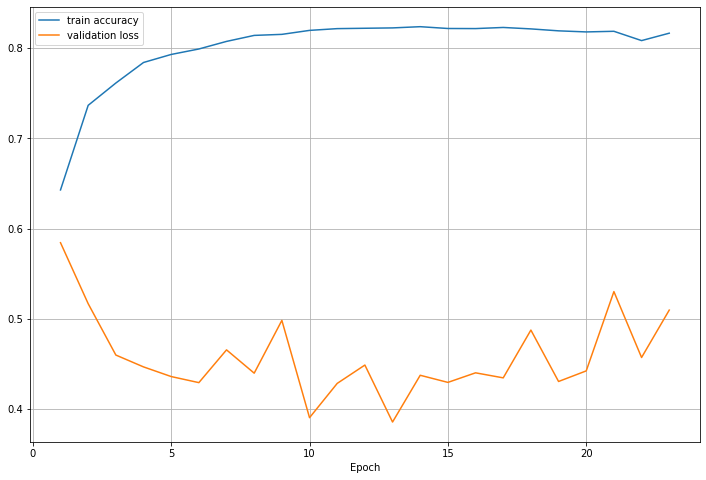

In [89]:
plt.figure(figsize=(12,8))
plt.plot(xs, y_acc, label='train accuracy')
plt.plot(xs, y_vloss, label='validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.show()